In [1]:
import sys
print(sys.path)

import numpy as np
import pandas as pd
import uproot as ur

from keras.layers import Dense, Input
from keras.models import Model

import omnifold as of
import os
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()

['/global/u1/k/kdevero/hiccup_projects/pp_unfolding', '/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python39.zip', '/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9', '/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/lib-dynload', '', '/global/homes/k/kdevero/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages', '/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages', '/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/IPython/extensions', '/global/u1/k/kdevero/.ipython']


2023-07-19 07:31:47.809879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 07:31:50.126165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
print(tf.test.is_built_with_cuda())

[]
True


2023-07-19 07:31:55.990626: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


___
___

|   |   |   |
|---|---|---|
|Synthetic Generator-Level Sim   | $\theta_{0,G}$  | Truth-Level Sim  |
|Synthetic Reconstruction-Level Sim   | $\theta_{0,S}$   | Full Reco-Level Sim  |
|Natural Reconstruction  | $\theta_\mathrm{unknown,S}$  | Observed Detector Data  |
|Natural Truth   |$\theta_\mathrm{unknown,G}$   | Nature  |


# Omnifold for EEC unfolding, (energy_weight, R_L, jet_pt)

#### we assume all imported root files consist of `TTree preprocessed` consiting of three columns `energy_weight`, `R_L`, and `jet_pt`

### Define variables to unfold

In [3]:
obs_features = ["obs_energy_weight", "obs_R_L", "obs_jet_pt"]
gen_features = ["gen_energy_weight", "gen_R_L", "gen_jet_pt"]

labels = ["energy weight", "$R_L$", "jet $p_T$"]

dummyval = [-9999 for i in range(3)]

### Import "natural reco": ALICE measured (testing: PYTHIA8 generator-level)
### Import "natural truth": ALICE truth (testing: PYTHIA8 generator-level, unused during actuall unfolding) 

In [13]:
natural_file = "preprocess_tr_eff_sigmap2.root"
natural_tree = ur.open("%s:preprocessed"%(natural_file))
natural_df = natural_tree.arrays(library="pd") #open the TTree as a pandas data frame
#natural_df = natural_reco_df[natural_reco_df["obs_hfs_pt"] != 0] #remove empty entries

### Take a quick look at the data

In [14]:
natural_df.describe()

,gen_energy_weight,gen_R_L,gen_jet_pt,obs_energy_weight,obs_R_L,obs_jet_pt,obs_thrown
count,2.779551e+06,2.779551e+06,2.779551e+06,2.779551e+06,2.779551e+06,2.779551e+06,2.779551e+06
mean,4.612885e-03,2.568717e-01,2.750827e+01,-5.878186e+03,-5.878089e+03,-5.867514e+03,5.878777e-01
std,1.113615e-02,1.532965e-01,5.276562e+00,4.921681e+03,4.921798e+03,4.934428e+03,4.922170e-01
min,1.464898e-05,0.000000e+00,2.000160e+01,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00
25%,6.140266e-04,1.427859e-01,2.305824e+01,-9.999000e+03,-9.999000e+03,-9.999000e+03,0.000000e+00
50%,1.681536e-03,2.485288e-01,2.653792e+01,-9.999000e+03,-9.999000e+03,-9.999000e+03,1.000000e+00
75%,4.551469e-03,3.604377e-01,3.133224e+01,1.583496e-03,1.920013e-01,2.371305e+01,1.000000e+00
max,1.000000e+00,8.997835e-01,3.999644e+01,1.000000e+00,8.487079e-01,3.991891e+01,1.000000e+00


In [15]:
natural_df.head(10)

,gen_energy_weight,gen_R_L,gen_jet_pt,obs_energy_weight,obs_R_L,obs_jet_pt,obs_thrown
0,0.003826,0.000000,38.481551,0.004109,0.000000,36.911131,0.0
1,0.000886,0.532620,38.481551,0.000959,0.529147,36.911131,0.0
2,0.000829,0.525144,38.481551,0.000907,0.518598,36.911131,0.0
3,0.003248,0.247525,38.481551,-9999.000000,-9999.000000,-9999.000000,1.0
4,0.006522,0.431914,38.481551,0.007006,0.428856,36.911131,0.0
5,0.005214,0.360886,38.481551,0.005631,0.358359,36.911131,0.0
6,0.004160,0.432882,38.481551,0.004443,0.438719,36.911131,0.0
7,0.028960,0.361527,38.481551,0.032054,0.351557,36.911131,0.0
8,0.008348,0.347887,38.481551,0.009146,0.343450,36.911131,0.0
9,0.000886,0.532620,38.481551,0.000959,0.529147,36.911131,0.0


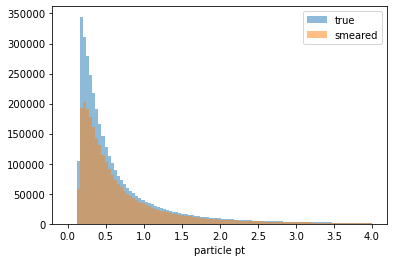

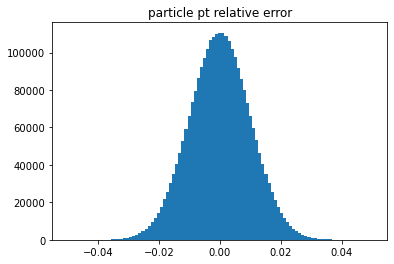

number truth parts = 3680460
number det   parts = 2748279
percentage = 0.7467216054514925


In [18]:
# particle pt relative error
part_pt_tree = ur.open("%s:particle_pt"%(natural_file))
part_pt_df = part_pt_tree.arrays(library="pd")
#part_pt_df = part_pt_df[part_pt_df['obs_pt'] != -9999]
part_pt = part_pt_df['gen_pt']
part_pt_smeared = part_pt_df['obs_pt']

binning = np.linspace(0, 4, 100)
plt.hist(part_pt, binning, alpha=0.5, label='true')
plt.hist(part_pt_smeared, binning, alpha=0.5, label='smeared')
plt.legend()
plt.xlabel('particle pt')
plt.show()

binning = np.linspace(-0.05, 0.05, 100)
plt.hist( (part_pt_smeared - part_pt) / part_pt, binning)
plt.title('particle pt relative error')
plt.show()

print("number truth parts = " + str(len(part_pt)))
print("number det   parts = " + str(len(np.unique(part_pt_smeared))))
print("percentage = " + str(len(np.unique(part_pt_smeared))/len(part_pt)))

### Jet pt resolution

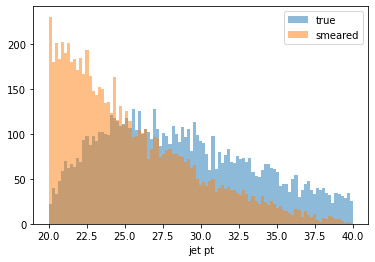

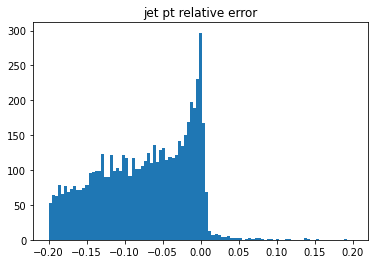

In [17]:
# jet pt relative error
jet_pt_tree = ur.open("%s:jet_pt"%(natural_file))
jet_pt_df = jet_pt_tree.arrays(library="pd")
jet_pt = jet_pt_df['gen_pt']
jet_pt_smeared = jet_pt_df['obs_pt']

binning = np.linspace(20, 40, 100)
plt.hist(jet_pt, binning, alpha=0.5, label='true')
plt.hist(jet_pt_smeared, binning, alpha=0.5, label='smeared')
plt.legend()
plt.xlabel('jet pt')
plt.show()

binning = np.linspace(-0.2, 0.2, 100)
plt.hist( (jet_pt_smeared - jet_pt) / jet_pt, binning)
plt.title('jet pt relative error')
plt.show()

### Import "synthetic simulation", both generated and reconstructed level.

In [11]:
synthetic_file = "preprocess_tr_eff.root"
synth_tree = ur.open("%s:preprocessed"%(synthetic_file))
synth_df = synth_tree.arrays(library="pd")
#synth_df = synth_df[synth_df["obs_hfs_pt"] != 0]

In [ ]:
synth_df.tail(10) #look at some entries

### define 4 main datasets

In [ ]:
theta_unknown_S = natural_df[obs_features].to_numpy() #Reconstructed Data
theta_unknown_G = natural_df[gen_features].to_numpy() #Nature, which unfolded data approaches

theta0_S = synth_df[obs_features].to_numpy() #Simulated, synthetic reco-level
theta0_G = synth_df[gen_features].to_numpy() #Generated, synthetic truth-level

obs_thrown = synth_df['obs_thrown'].to_numpy() # binary if pair DOESN'T pass efficiency cut

### Ensure the samples have the same number of entries

In [ ]:
N_Events = min(np.shape(theta0_S)[0],np.shape(theta_unknown_S)[0])-1

# Synthetic
theta0_S = theta0_S[:N_Events]
theta0_G = theta0_G[:N_Events]

theta0 = np.stack([theta0_S, theta0_G], axis=1)

# Natural
theta_unknown_S = theta_unknown_S[:N_Events]
theta_unknown_G = theta_unknown_G[:N_Events]

obs_thrown = obs_thrown[:N_Events]

In [ ]:
N = len(obs_features)

binning = [np.logspace(-5,0,100),np.logspace(-4,0,100),np.linspace(20,40,100)]

fig, axes = plt.subplots(1, 3, figsize=(15,4))

obs_i = 0

for i,ax in enumerate(axes.ravel()):
    if (i >= N): break
    _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
    _,_,_=ax.hist(theta0_S[:,i][obs_thrown!=1],binning[i],histtype="step",color='black',ls=':',label="MC, reco")
    _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='orange',alpha=0.5,label="Data, true")
    _,_,_=ax.hist(theta_unknown_S[:,i][obs_thrown!=1],binning[i],histtype="step",color='black',label="Data, reco")

    ax.set_title(labels[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel("Events")
    ax.legend(frameon=False)
    
    if obs_i in [0, 1]:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    obs_i += 1
    
fig.tight_layout()

In [ ]:
inputs = Input((len(obs_features), ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_dis = Model(inputs=inputs, outputs=outputs)

In [ ]:
print(theta0_G.shape)
print(theta0_S.shape)
print(theta_unknown_S.shape)

print(theta0_G[theta0_S[:,0]==-9999])
print(theta0_G[theta0_S[:,0]==-9999].shape)

In [ ]:
N_Iterations = 2
myweights = of.omnifold_tr_eff(theta0,theta_unknown_S,N_Iterations,model_dis,dummyval=-9999)

In [ ]:
binning = [np.logspace(-5,0,100),np.logspace(-4,0,100),np.linspace(20,40,100)]

for iteration in range(N_Iterations):
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    obs_i = 0

    for i,ax in enumerate(axes.ravel()):
        if (i >= N): break
        _,_,_=ax.hist(theta0_G[:,i],binning[i],color='blue',alpha=0.5,label="MC, true")
        _,_,_=ax.hist(theta_unknown_G[:,i],binning[i],color='orange',alpha=0.5,label="Data, true")
        _,_,_=ax.hist(theta0_G[:,i],weights=myweights[iteration, 0, :],bins=binning[i],color='black',histtype="step",label="OmniFolded",lw="2")

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("Events")
        ax.legend(frameon=False)

        if obs_i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')

        obs_i += 1
    
    fig.tight_layout()

___
___

### true vs smeared EEC calculation

In [ ]:
binning = np.logspace(-4, np.log10(0.4), 100)

_,_,_=plt.hist(theta0_G[:,1], binning, weights=theta0_G[:,0], color='blue', alpha=0.5, label="MC, true") # true
_,_,_=plt.hist(theta0_S[:,1], binning, weights=theta0_S[:,0], color='orange', alpha=0.5, label="data, smeared") # smeared
_,_,_=plt.hist(theta0_G[:,1] * myweights[-1, 0, :], binning, weights=theta0_G[:,0] * myweights[-1, 0, :], color='black', histtype="step", label="OmniFolded", lw="2") # omnifolded

plt.xscale('log')
plt.yscale('log')

plt.xlabel("$R_L$")
plt.ylabel("cs")
plt.title("EEC calculation")
plt.legend(frameon=False, loc='upper left')

In [ ]:
myweights[-1]

In [ ]:
myweights

In [ ]:
pass_reco = np.random.binomial(1,0.9,30)

In [ ]:
pass_reco